In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
import pickle
from calcwf import *
from interpolating_match import *

Let's first take a look at the (quad) mismatch between harmonics generated at different fiducial eccentricities with the non-eccentric waveform along the degeneracy line for different chirp masses.

In [2]:
# Find mismatches for a range of fid_e values
def find_quad_mismatches(chirp, fid_es, n, q=2, f_low=10, sample_rate=4096, approximant='TEOBResumS'):

    # Generate non-eccentric waveform
    h = gen_wf(f_low, 0, chirp2total(chirp, q), q, sample_rate, approximant)

    # Generate chirp masses along degeneracy line
    fid_chirps = chirp_degeneracy_line(chirp, fid_es, sample_rate, f_low=f_low, q=q)

    # Calculate mismatch for each fid_e
    mismatches = []
    for i, (fid_e, fid_chirp) in enumerate(zip(fid_es, fid_chirps)):
        all_wfs = list(get_h([1]*n, f_low, fid_e, chirp2total(fid_chirp, q), q, sample_rate, approximant=approximant))
        matches = match_hn(all_wfs[1:n+1], h, f_low)
        quad_match = np.sqrt(np.sum(np.abs(matches)**2))
        mismatches.append(1-quad_match)
        print(f'\r{i+1} done out of {len(fid_es)}', end='')
    print('')

    return np.array(mismatches)

In [3]:
# Calculate mismatches for 10, 30, and 70 chirp masses
mismatches_10 = find_quad_mismatches(10, np.linspace(0,0.15,16), 4)
mismatches_30 = find_quad_mismatches(30, np.linspace(0,0.30,31), 4)
mismatches_70 = find_quad_mismatches(70, np.linspace(0,0.50,51), 4)

/home/ben.patterson/.conda/envs/teobresums_eccentric/lib/python3.10/site-packages/pycbc/types/array.py:435: RuntimeWarning: divide by zero encountered in power
  return self._data ** other
/home/ben.patterson/.conda/envs/teobresums_eccentric/lib/python3.10/site-packages/pycbc/types/array.py:348: RuntimeWarning: invalid value encountered in multiply
  return self._data * other


16 done out of 16
31 done out of 31
51 done out of 51


(0.0, 0.007)

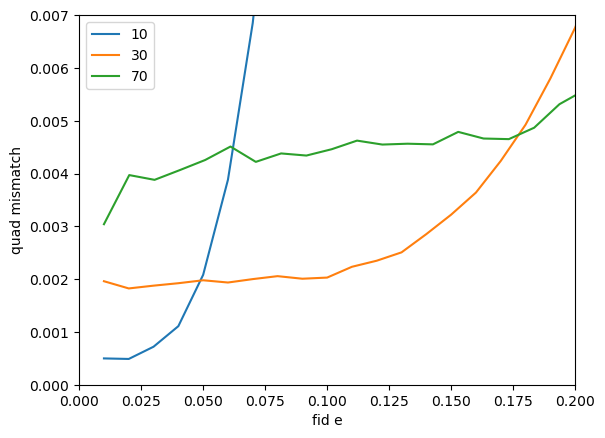

In [4]:
plt.plot(np.linspace(0.01,0.15,15), mismatches_10[1:], label='10')
plt.plot(np.linspace(0.01,0.30,30), mismatches_30[1:], label='30')
plt.plot(np.linspace(0.01,0.51,50), mismatches_70[1:], label='70')
plt.legend()
plt.xlabel('fid e')
plt.ylabel('quad mismatch')
plt.xlim(0,0.2)
plt.ylim(0,0.007)

Seems like this idea of holding the quad mismatch constant is unlikely to work based on this. What if we try mismatch with a teobresums wf instead of our harmonics?

In [3]:
# Find mismatches for a range of fid_e values
def find_mismatches(chirp, fid_es, q=2, f_low=10, sample_rate=4096, approximant='TEOBResumS'):

    # Generate non-eccentric waveform
    h = gen_wf(f_low, 0.001, chirp2total(chirp, q), q, sample_rate, approximant)

    # Generate chirp masses along degeneracy line
    fid_chirps = chirp_degeneracy_line(chirp, fid_es, sample_rate, f_low=f_low, q=q)

    # Calculate mismatch for each fid_e
    mismatches = []
    for i, (fid_e, fid_chirp) in enumerate(zip(fid_es, fid_chirps)):
        s = gen_wf(f_low, fid_e, chirp2total(fid_chirp, q), q, sample_rate, approximant)
        match = match_wfs(s, h, f_low, True)
        mismatches.append(1-match)
        print(f'\r{i+1} done out of {len(fid_es)}', end='')
    print('')

    return np.array(mismatches)

In [6]:
mismatch_10 = find_mismatches(10, np.linspace(0,0.15,16))
mismatch_30 = find_mismatches(30, np.linspace(0,0.30,31))
mismatch_70 = find_mismatches(70, np.linspace(0,0.50,51))

16 done out of 16
31 done out of 31
51 done out of 51


(0.0, 0.22903198817679557)

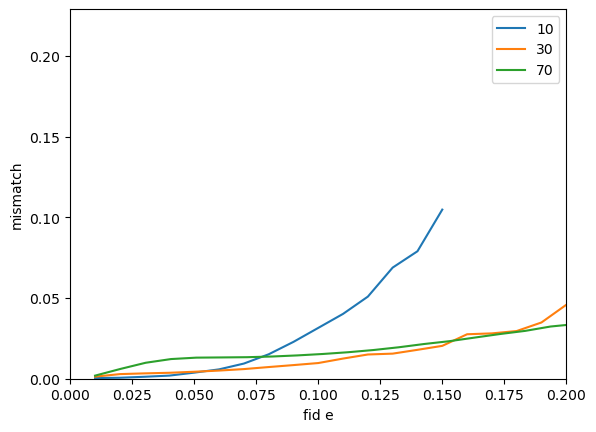

In [7]:
plt.plot(np.linspace(0.01,0.15,15), mismatch_10[1:], label='10')
plt.plot(np.linspace(0.01,0.30,30), mismatch_30[1:], label='30')
plt.plot(np.linspace(0.01,0.51,50), mismatch_70[1:], label='70')
plt.legend()
plt.xlabel('fid e')
plt.ylabel('mismatch')
plt.xlim(0,0.2)
plt.ylim(0)

Also tried giving non-eccentric teobresums wf e=0.001 here, but seems like trying to do this numerically will not work - may instead have to try it analytically by looking at equations similar to those used to derive our line of degeneracy.

First let's look at min/max lines for different fiducial eccentricities at an eccentric chirp mass of 30.

## 30 chirp mass min/max lines

In [12]:
with open(os.path.join('grid_data', 'dataslot_22', 'all_matches'), 'rb') as fp:
        grid_data_30_fid_es = pickle.load(fp)
grid_data_30_fid_es = find_min_max(grid_data_30_fid_es)

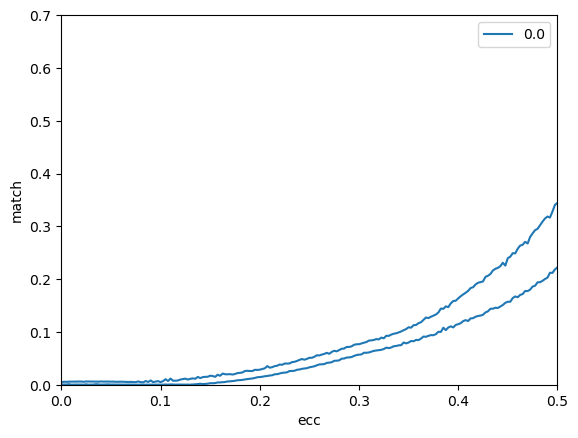

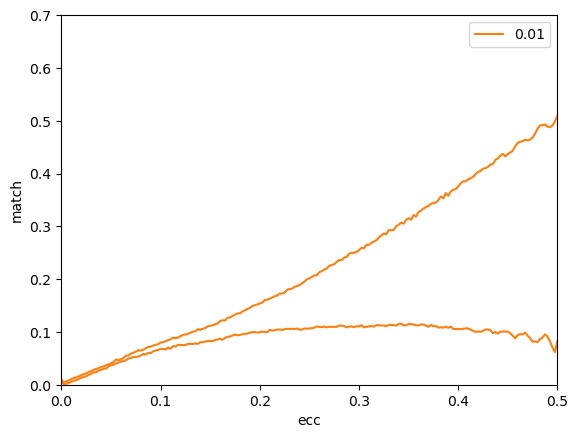

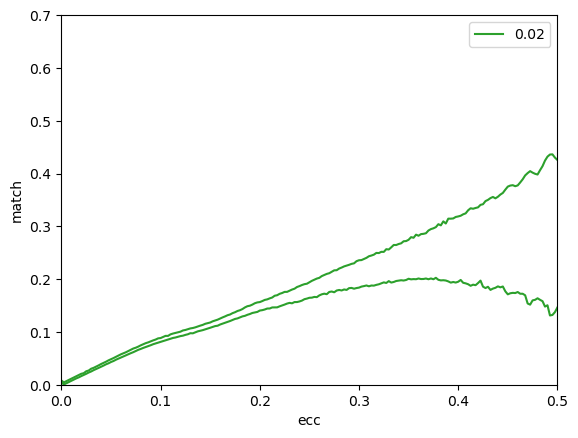

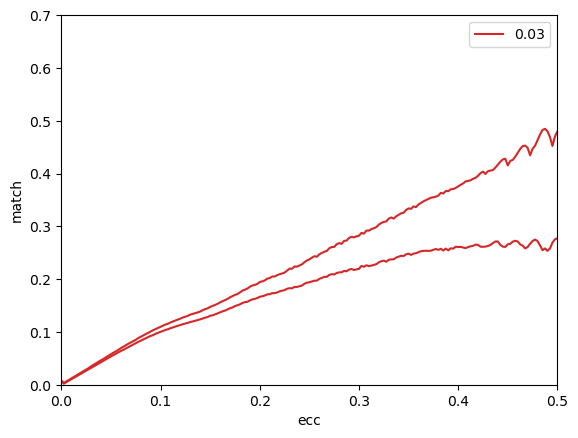

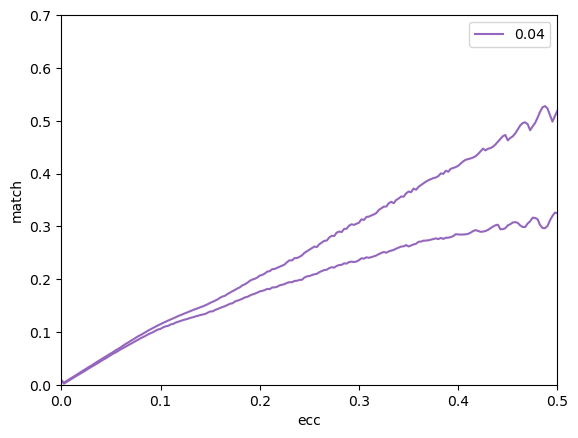

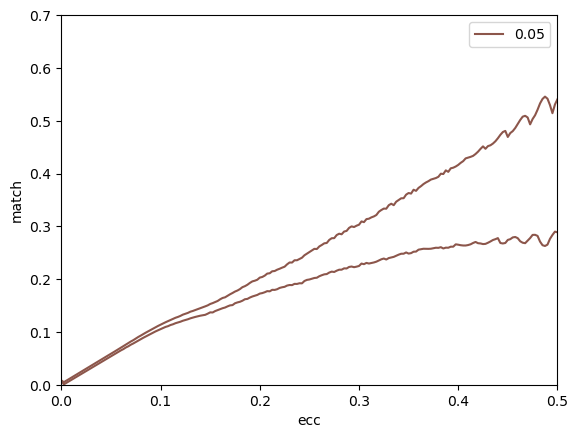

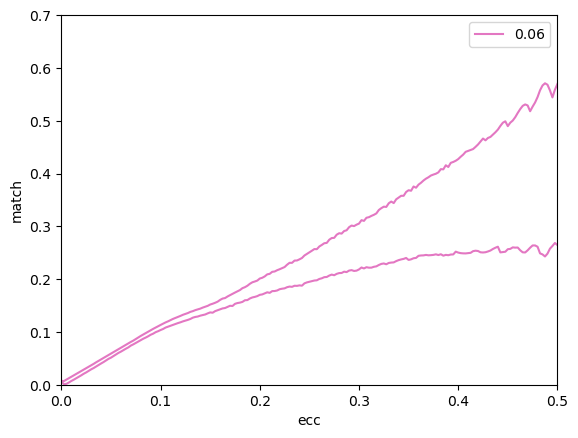

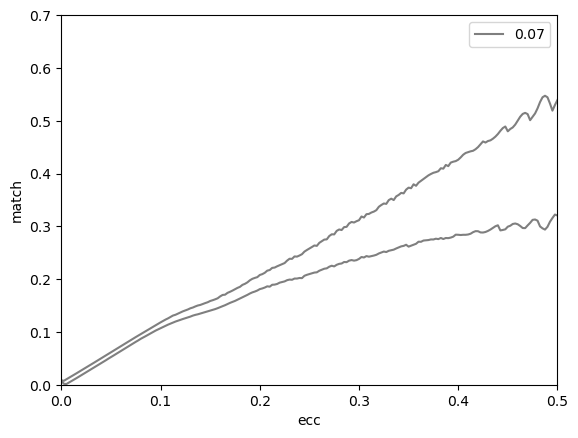

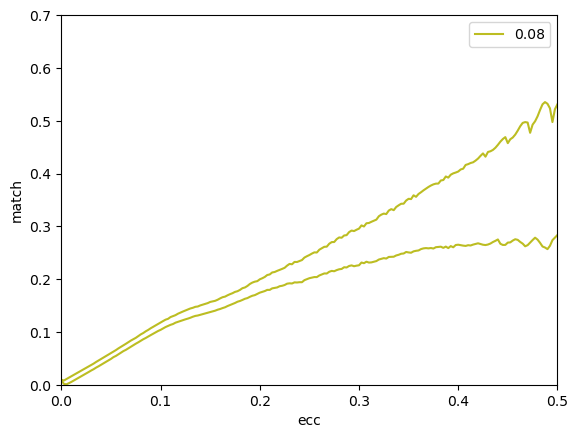

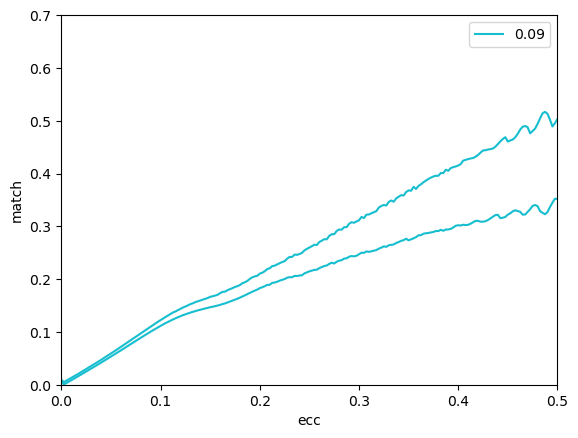

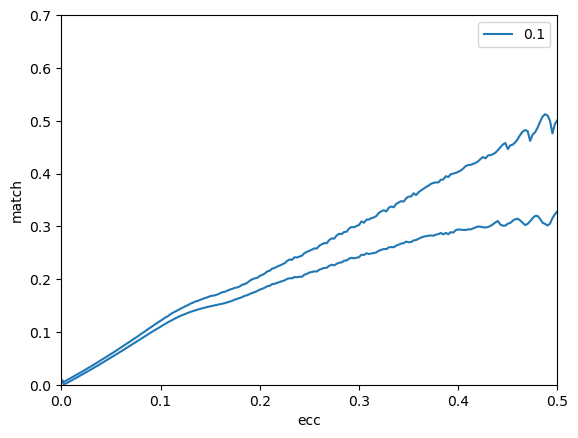

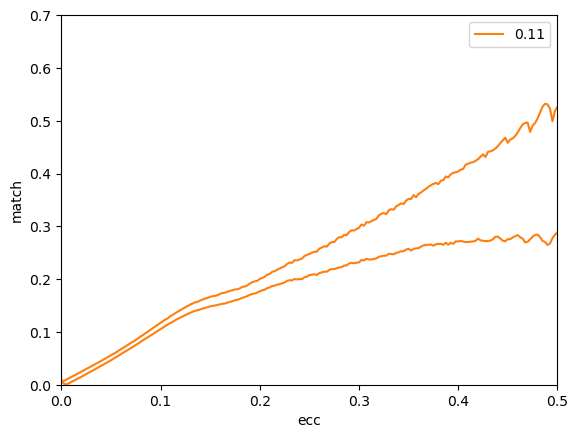

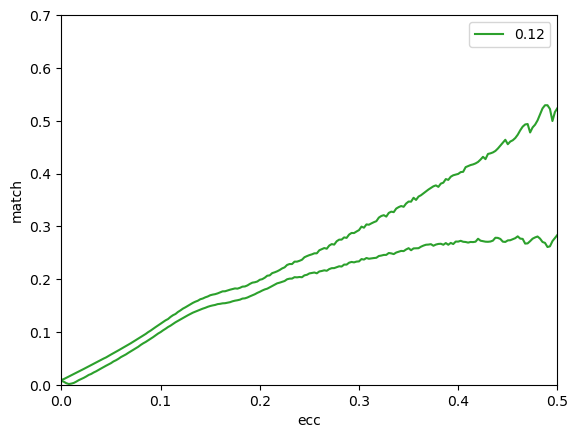

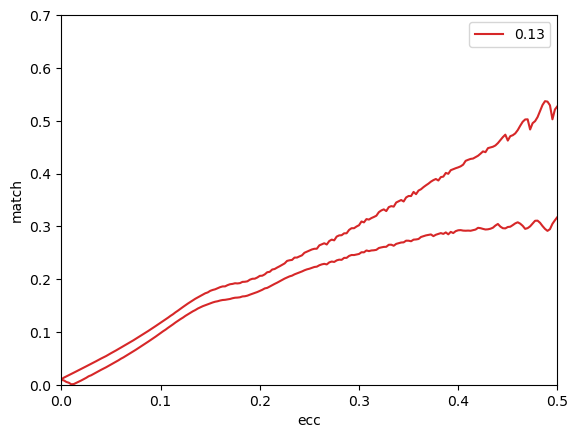

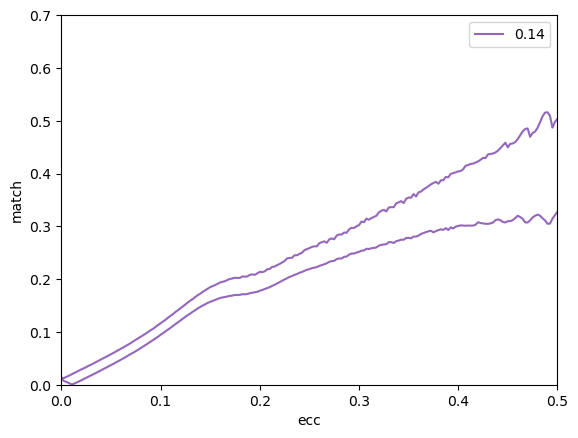

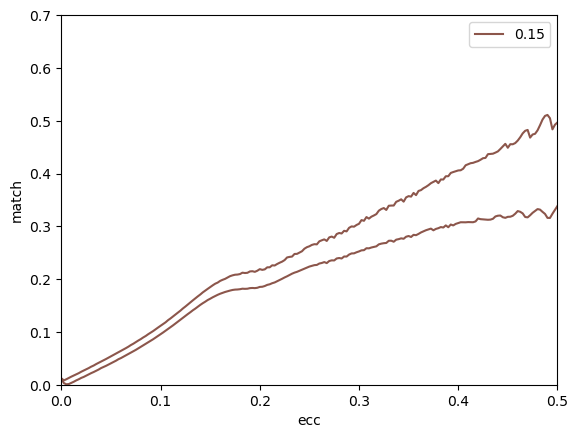

In [19]:
cmap = mpl.colormaps['inferno']
for i, fid_e in enumerate(grid_data_30_fid_es.keys()):
    fid_e_arg = int((fid_e-grid_data_30_fid_es[fid_e]['e_vals'][0])/np.mean(np.diff(grid_data_30_fid_es[fid_e]['e_vals'])))
    fid_e_match_max = grid_data_30_fid_es[fid_e]['h2_h1_max'][fid_e_arg]
    fid_e_match_min = grid_data_30_fid_es[fid_e]['h2_h1_min'][fid_e_arg]
    y_norm = (fid_e_match_max+fid_e_match_min)/2
    plt.plot(grid_data_30_fid_es[fid_e]['e_vals'], grid_data_30_fid_es[fid_e]['h2_h1_max'], c=f'C{i}', label=str(fid_e))
    plt.plot(grid_data_30_fid_es[fid_e]['e_vals'], grid_data_30_fid_es[fid_e]['h2_h1_min'], c=f'C{i}')
    plt.legend()
    plt.ylabel('match')
    plt.xlabel('ecc')
    plt.xlim(0,0.5)
    plt.ylim(0,0.7)
    plt.show()

## 18 chirp mass min/max lines

In [14]:
with open(os.path.join('grid_data', 'dataslot_23', 'all_matches'), 'rb') as fp:
        grid_data_18_fid_es = pickle.load(fp)
grid_data_18_fid_es = find_min_max(grid_data_18_fid_es)

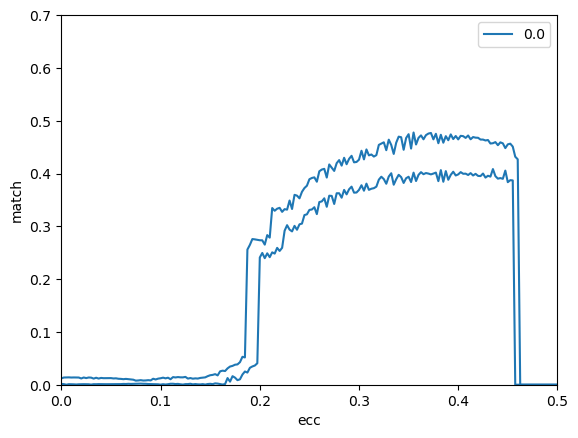

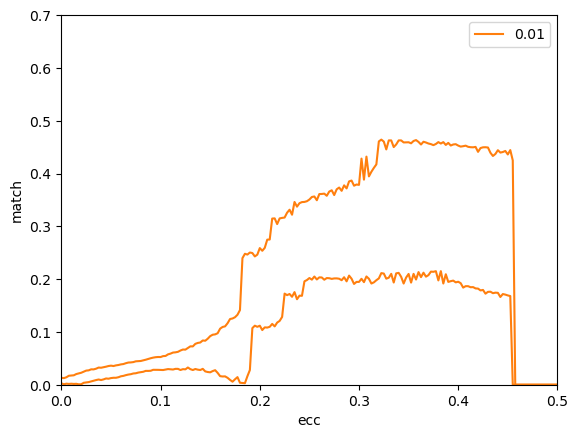

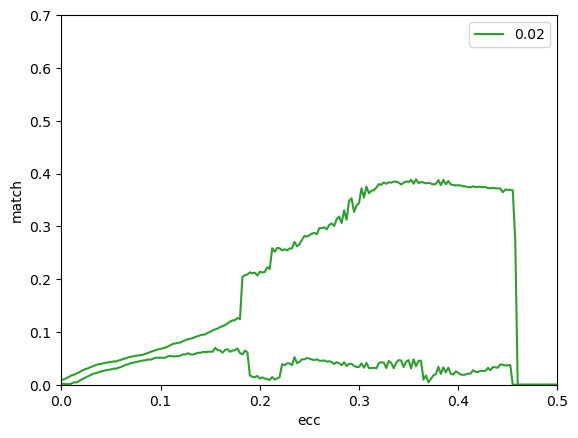

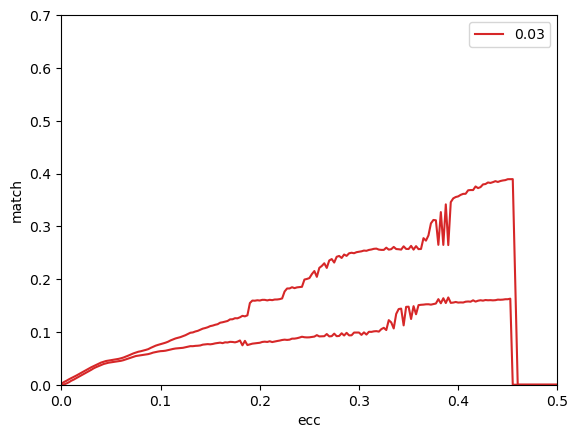

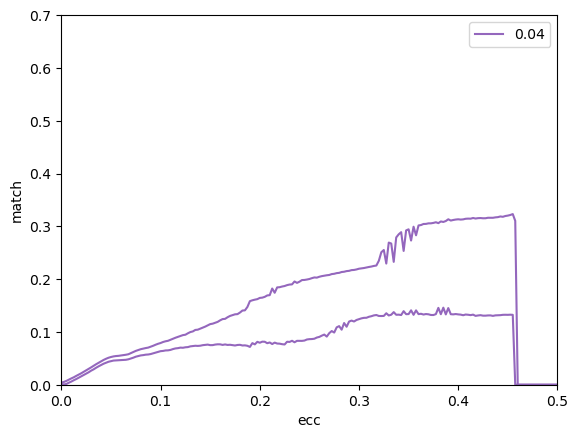

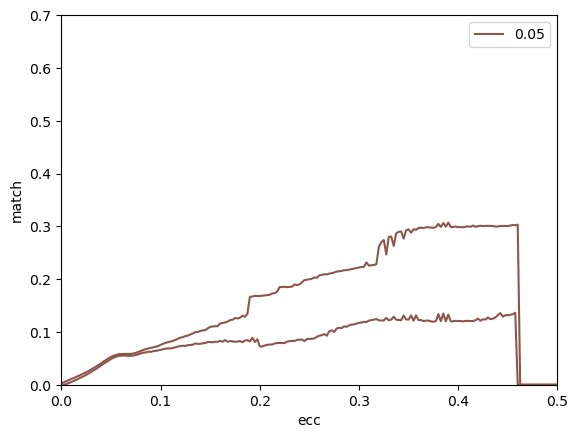

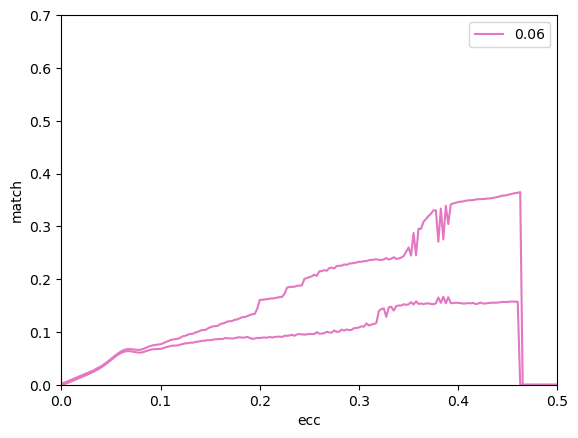

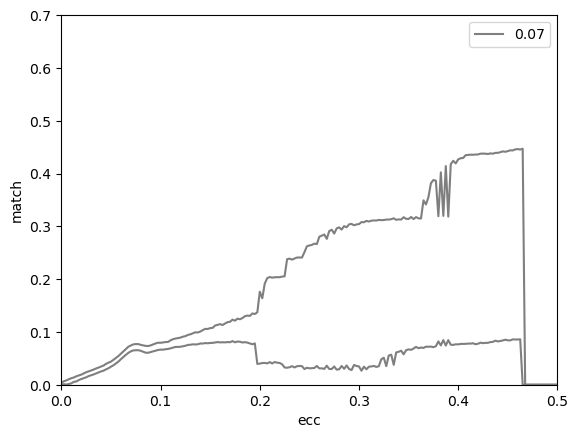

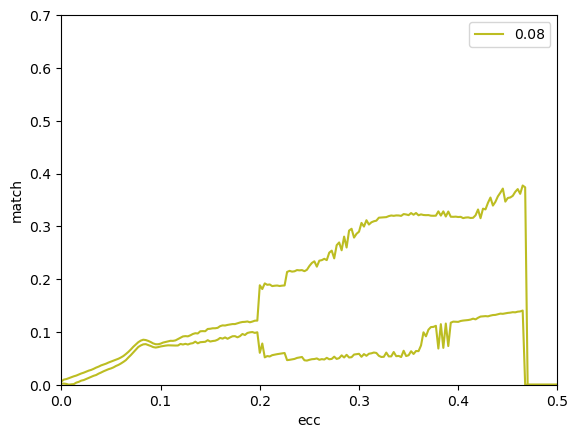

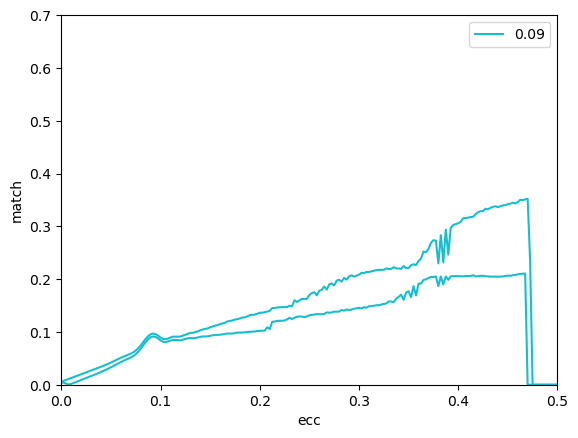

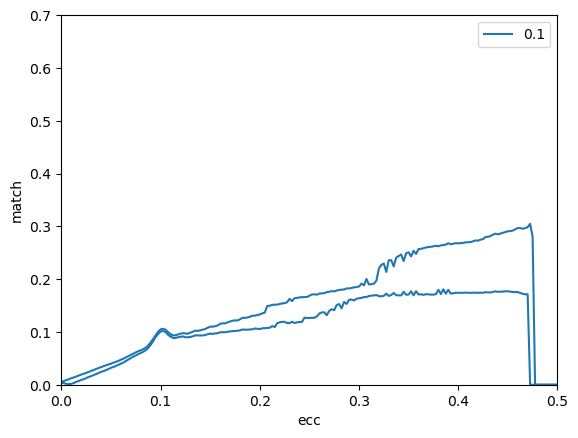

In [20]:
cmap = mpl.colormaps['inferno']
for i, fid_e in enumerate(grid_data_18_fid_es.keys()):
    fid_e_arg = int((fid_e-grid_data_18_fid_es[fid_e]['e_vals'][0])/np.mean(np.diff(grid_data_18_fid_es[fid_e]['e_vals'])))
    fid_e_match_max = grid_data_18_fid_es[fid_e]['h2_h1_max'][fid_e_arg]
    fid_e_match_min = grid_data_18_fid_es[fid_e]['h2_h1_min'][fid_e_arg]
    y_norm = (fid_e_match_max+fid_e_match_min)/2
    plt.plot(grid_data_18_fid_es[fid_e]['e_vals'], grid_data_18_fid_es[fid_e]['h2_h1_max'], c=f'C{i}', label=str(fid_e))
    plt.plot(grid_data_18_fid_es[fid_e]['e_vals'], grid_data_18_fid_es[fid_e]['h2_h1_min'], c=f'C{i}')
    plt.legend()
    plt.ylabel('match')
    plt.xlabel('ecc')
    plt.xlim(0,0.5)
    plt.ylim(0,0.7)
    plt.show()

## 10 chirp mass min/max lines

In [16]:
with open(os.path.join('grid_data', 'dataslot_24', 'all_matches'), 'rb') as fp:
        grid_data_10_fid_es = pickle.load(fp)
grid_data_10_fid_es = find_min_max(grid_data_10_fid_es)

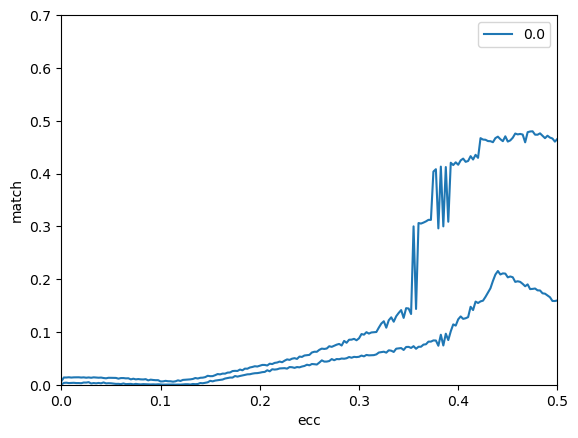

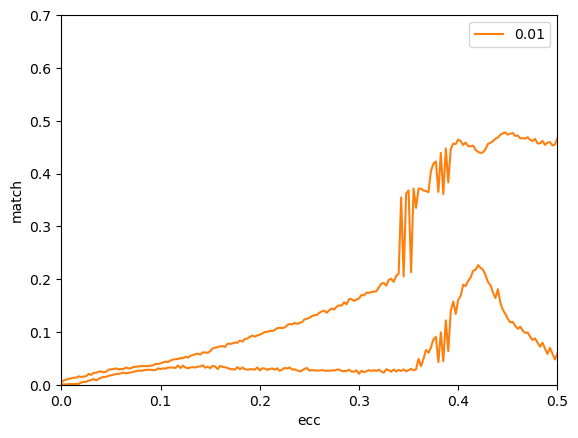

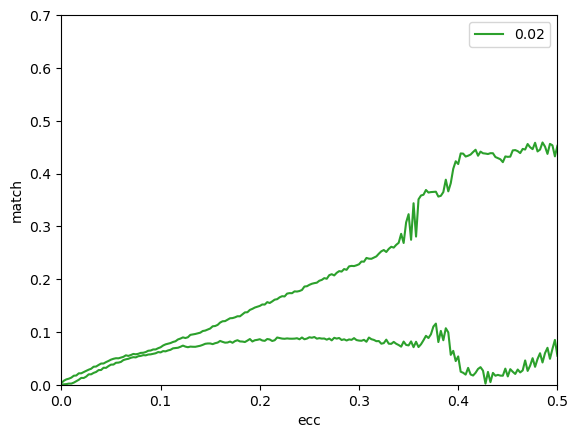

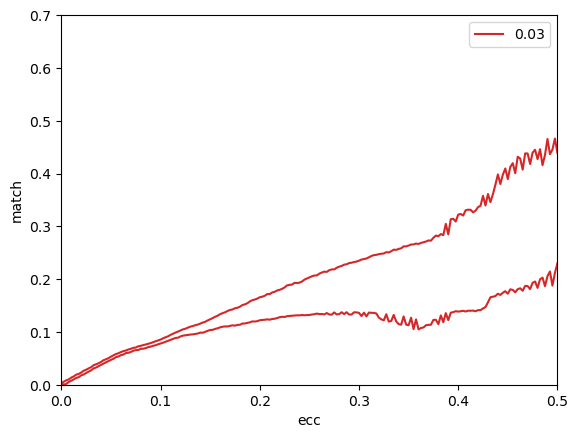

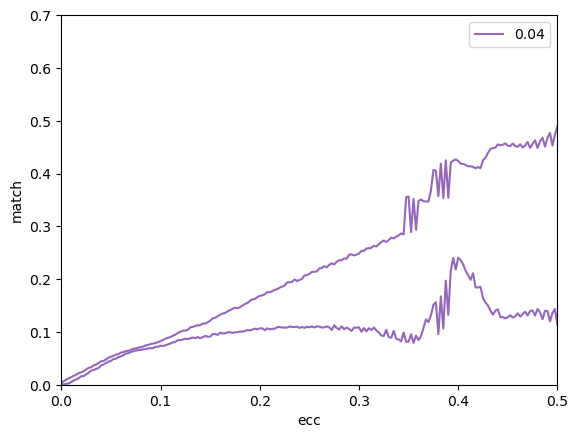

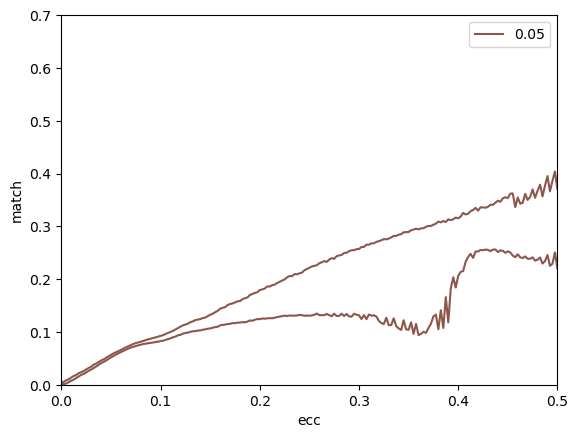

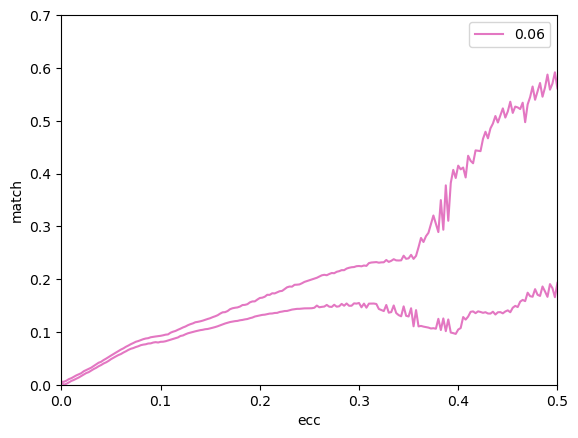

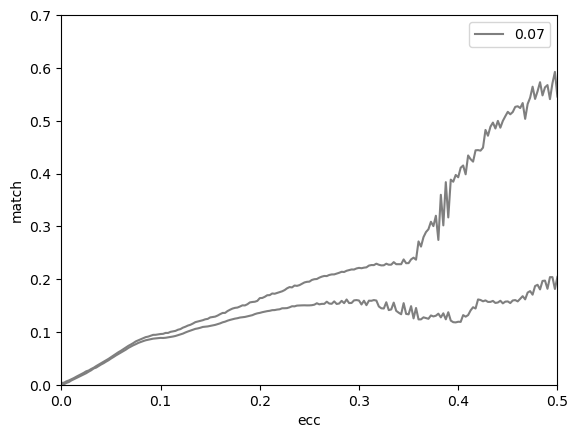

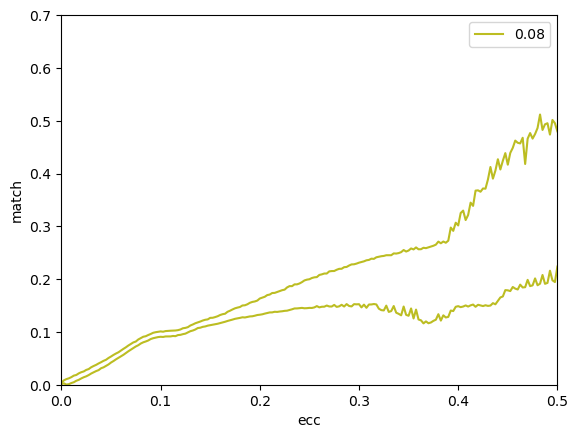

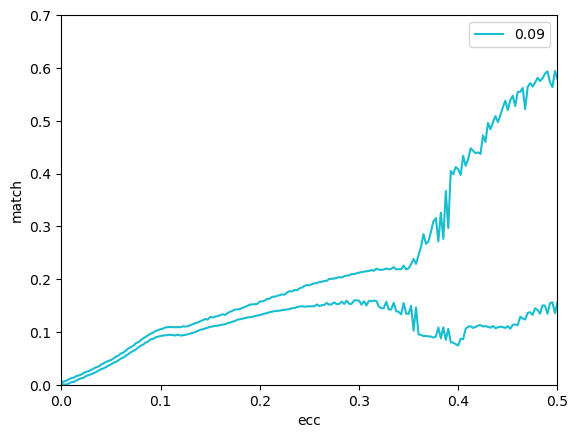

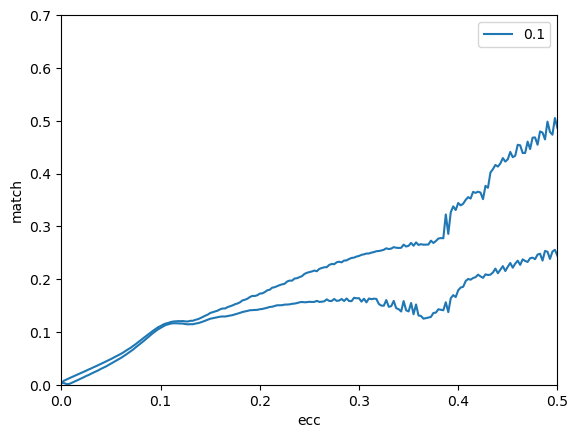

In [22]:
cmap = mpl.colormaps['inferno']
for i, fid_e in enumerate(grid_data_10_fid_es.keys()):
    fid_e_arg = int((fid_e-grid_data_10_fid_es[fid_e]['e_vals'][0])/np.mean(np.diff(grid_data_10_fid_es[fid_e]['e_vals'])))
    fid_e_match_max = grid_data_10_fid_es[fid_e]['h2_h1_max'][fid_e_arg]
    fid_e_match_min = grid_data_10_fid_es[fid_e]['h2_h1_min'][fid_e_arg]
    y_norm = (fid_e_match_max+fid_e_match_min)/2
    plt.plot(grid_data_10_fid_es[fid_e]['e_vals'], grid_data_10_fid_es[fid_e]['h2_h1_max'], c=f'C{i}', label=str(fid_e))
    plt.plot(grid_data_10_fid_es[fid_e]['e_vals'], grid_data_10_fid_es[fid_e]['h2_h1_min'], c=f'C{i}')
    plt.legend()
    plt.ylabel('match')
    plt.xlabel('ecc')
    plt.xlim(0,0.5)
    plt.ylim(0,0.7)
    plt.show()

## 

It is clear here that lower chirp masses do indeed require lower fiducial eccentricities. Also true however is that lower chirp masses are unable to go to as high eccentricities before the min/max lines start to 'turn over' or just become weird. This makes sense, as lower chirp masses have more of the signal in band so the assumption that only the amplitude of harmonics changes as you change eccentricity is less valid.

What is more puzzling however is that the 18 chirp mass appears to 'fail' at lower eccentricities than the 10 chirp mass lines. This seems very counterintuitive for me, and could be challenging for what we are trying to achieve.

Turning to which fiducial eccentricity works best for each chirp mass, very roughly I would say the following:
- 30: 0.09
- 18: 0.03
- 10: 0.03

This is very rough however with the 'niceness' of the min/max lines changing often fairly significantly between fiducial eccentricity values, and I especially do not have much trust in the 18 chirp mass data point. 

## Trying to find fiducial eccentricity scaling analytically

By looking at match equations used to derive the degeneracy line we may be able to analytically find the best fiducial eccentricity for each chirp mass (or at least the scaling which we can then normalise).

We start from the following equation for the square of the match:

$$
1 - a^2 \hat{\mathcal{M}}^{-10/3} \left[ \delta m^2 \left(\overline{f^{-10/3}} - \overline{f^{-5/3}}^2 \right) + 2 \delta m \left(\overline{kf^{-10/3}} - \overline{f^{-5/3}} \; \overline{kf^{-5/3}}\right) + \left( \overline{k^2f^{-10/3}} - \overline{kf^{-5/3}}^2\right)\right].
$$

As a reminder, $a$ is just constants, $\mathcal{M}$ is the chirp mass at zero eccentricity, $k$ is a function of eccentricity, and $\delta m$ is a parameter describing the change in chirp mass along the line, which we have solved to equal the following along the degeneracy line:

$$
\delta m = - \frac{\left(\overline{kf^{-10/3}} - \overline{f^{-5/3}} \; \overline{kf^{-5/3}}\right)}{\left(\overline{f^{-10/3}} - \overline{f^{-5/3}}^2 \right)}.
$$

We can then substitute this in to recover (and recognise we only need to keep the mismatch component constant, so will drop the preceding $1-$ for simplicity):

$$
a^2 \hat{\mathcal{M}}^{-10/3} \left[ - \left(\overline{kf^{-10/3}} - \overline{f^{-5/3}} \; \overline{kf^{-5/3}}\right)^2/\left(\overline{f^{-10/3}} - \overline{f^{-5/3}}^2 \right) + \left( \overline{k^2f^{-10/3}} - \overline{kf^{-5/3}}^2\right)\right].
$$

We can now see that the scaling is approximately $\hat{\mathcal{M}}^{-10/3} e^4$ using $k \sim e^2$. We should therefore use a scaling of $e \sim \hat{\mathcal{M}}^{5/6}$